# Model

In [1]:
%matplotlib inline
from vgg16 import *
from utils import *

path = 'data/sample/'
model_path = 'data/sample/model/'

Using Theano backend.


In [2]:
vgg = vgg16()

### Get imagenet predictions

In [33]:
batch_size = 3

Found 800 images belonging to 9 classes.


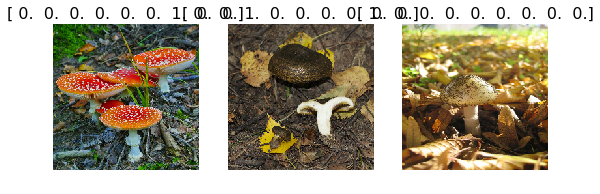

In [35]:
batches = get_batches(path+'train', batch_size=batch_size)

imgs,labels = next(batches)

plots(imgs, titles=labels)

In [36]:
vgg.predict(imgs)

array([[  1.54398705e-12,   8.20997215e-10,   1.76103910e-13, ...,
          1.84615317e-04,   1.28042660e-10,   6.15485107e-14],
       [  9.73439819e-06,   5.26380381e-06,   3.89650978e-08, ...,
          7.74833858e-02,   1.18834059e-05,   1.69675502e-06],
       [  9.71541085e-05,   1.83169177e-05,   5.70492512e-06, ...,
          1.74976572e-01,   2.34940249e-04,   8.80123139e-07]], dtype=float32)

### VGG on precalculated data

In [3]:
layers = vgg.layers
last_conv_idx = [index for index,layer in enumerate(layers) if type(layer) is Conv2D][-1]
conv_layers = layers[:last_conv_idx+1]
dense_layers = layers[last_conv_idx+1:]

conv_model = Sequential(conv_layers)

In [47]:
trn_batches = get_batches(path+'train', batch_size=1, shuffle=False)
val_batches = get_batches(path+'valid', batch_size=1, shuffle=False)

Found 701 images belonging to 9 classes.
Found 181 images belonging to 9 classes.


In [48]:
trn_classes = trn_batches.classes
trn_labels = onehot(trn_classes)

val_classes = val_batches.classes
val_labels = onehot(val_classes)

In [49]:
trn_conv_features = conv_model.predict_generator(trn_batches, trn_batches.samples//trn_batches.batch_size, verbose = 1)
val_conv_features = conv_model.predict_generator(val_batches, val_batches.samples//val_batches.batch_size, verbose = 1)

181/181 [==============================] - 112s   


In [50]:
save_array(model_path + 'trn_conv_feat.dat', trn_conv_features)
trn_conv_features = load_array(model_path + 'trn_conv_feat.dat')

save_array(model_path + 'val_conv_feat.dat', val_conv_features)
val_conv_features = load_array(model_path + 'val_conv_feat.dat')

In [103]:
#from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.layers.normalization import BatchNormalization
def get_dense_model():
    model = Sequential()
    model.add(MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]))
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    BatchNormalization(),
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    BatchNormalization(),
    model.add(Dropout(0.3))
    model.add(Dense(9, activation='softmax'))
    model.compile(SGD(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [104]:
dense_model = get_dense_model()

In [85]:
dense_model.optimizer.lr = 0.00045

In [105]:
dense_model.fit(trn_conv_features, trn_labels, epochs = 1000, batch_size = 800,
               validation_data=(val_conv_features, val_labels),
               callbacks = [EarlyStopping(monitor='val_acc', patience=30, verbose=1, min_delta=1e-4, mode='max'),
                           #ReduceLROnPlateau(monitor='val_acc', factor=0.3, patience=5, verbose=1, epsilon=1e-4, mode='max')
                            CSVLogger(model_path + 'learning_log.csv', separator=',', append=False),
                            ReduceLROnPlateau(monitor='val_acc', factor=0.3, patience=8, min_lr=0.00001, verbose = 1)
                           ])

Train on 701 samples, validate on 181 samples
Epoch 1/1000
701/701 [==============================] - 6s - loss: 13.0763 - acc: 0.1084 - val_loss: 10.5242 - val_acc: 0.1657
Epoch 2/1000
701/701 [==============================] - 5s - loss: 11.5743 - acc: 0.1812 - val_loss: 9.7378 - val_acc: 0.1989
Epoch 3/1000
701/701 [==============================] - 5s - loss: 10.7774 - acc: 0.2126 - val_loss: 9.0384 - val_acc: 0.2707
Epoch 4/1000
701/701 [==============================] - 5s - loss: 10.1450 - acc: 0.2625 - val_loss: 10.3642 - val_acc: 0.2541
Epoch 5/1000
701/701 [==============================] - 6s - loss: 9.4301 - acc: 0.3210 - val_loss: 8.1379 - val_acc: 0.3425
Epoch 6/1000
701/701 [==============================] - 5s - loss: 8.9974 - acc: 0.3338 - val_loss: 8.3237 - val_acc: 0.3757
Epoch 7/1000
701/701 [==============================] - 6s - loss: 8.8400 - acc: 0.3466 - val_loss: 8.7363 - val_acc: 0.3370
Epoch 8/1000
701/701 [==============================] - 5s - loss: 8.2747

701/701 [==============================] - 5s - loss: 0.7543 - acc: 0.9101 - val_loss: 2.3797 - val_acc: 0.7348
Epoch 66/1000
701/701 [==============================] - 5s - loss: 0.6376 - acc: 0.9116 - val_loss: 2.3586 - val_acc: 0.7403
Epoch 67/1000
701/701 [==============================] - 5s - loss: 0.4942 - acc: 0.9301 - val_loss: 2.3295 - val_acc: 0.7403
Epoch 68/1000
701/701 [==============================] - 5s - loss: 0.6227 - acc: 0.9215 - val_loss: 2.2637 - val_acc: 0.7403
Epoch 69/1000
701/701 [==============================] - 5s - loss: 0.6999 - acc: 0.9116 - val_loss: 2.2387 - val_acc: 0.7403
Epoch 70/1000
701/701 [==============================] - 5s - loss: 0.7191 - acc: 0.9101 - val_loss: 2.1806 - val_acc: 0.7459
Epoch 71/1000
701/701 [==============================] - 5s - loss: 0.8805 - acc: 0.8916 - val_loss: 2.1759 - val_acc: 0.7569
Epoch 72/1000
701/701 [==============================] - 5s - loss: 0.6580 - acc: 0.9158 - val_loss: 2.1682 - val_acc: 0.7459
Epoch 

### VGG on full data

In [49]:
layers = vgg.layers
last_conv_idx = [index for index,layer in enumerate(layers) if type(layer) is Conv2D][-1]
conv_layers = layers[:last_conv_idx+1]
dense_layers = layers[last_conv_idx+1:]

conv_model = Sequential(conv_layers)
for layer in conv_model.layers: layer.trainable=False

In [50]:
conv_model.add(MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]))
conv_model.add(Flatten())
conv_model.add(Dense(100, activation='relu'))
conv_model.add(Dropout(0.5))
conv_model.add(Dense(100, activation='relu'))
conv_model.add(Dropout(0.5))
conv_model.add(Dense(9, activation='softmax'))

In [54]:
conv_model.compile(Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [55]:
batch_size = 8
gen_t = image.ImageDataGenerator(rotation_range=15,
                                 height_shift_range=0.05,
                                 shear_range=0.1,
                                 channel_shift_range=20,
                                 width_shift_range=0.1)

batches = get_batches(path+'train', gen_t, batch_size=batch_size)

Found 800 images belonging to 9 classes.


In [56]:
val_batches = get_batches(path+'valid', batch_size=batch_size)

Found 200 images belonging to 9 classes.


In [58]:
conv_model.optimizer.lr=3e-5

In [59]:
conv_model.fit_generator(batches, steps_per_epoch=batches.samples//batches.batch_size, 
                  epochs=1, validation_steps=val_batches.samples//val_batches.batch_size,
                  validation_data=val_batches)

Epoch 1/1
100/100 [==============================] - 510s - loss: 10.9297 - acc: 0.2237 - val_loss: 9.0962 - val_acc: 0.3200
